# CSE404 Project - Fake News Detection

Required import and downloads used in the project

In [140]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import nltk
nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string

# import tensorflow as tf

# import keras
# from keras.preprocessing import text, sequence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayaan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Coding Data Reader

Loading in the data from the CSV data files `true_data.csv` and `false_data.csv`.

In [2]:
true_data = pd.read_csv("True.csv")
false_data = pd.read_csv("Fake.csv")

### Most occured words in true news

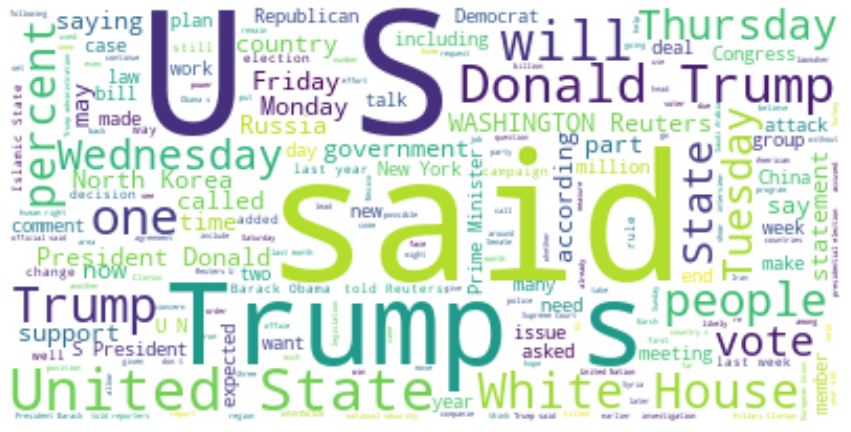

In [4]:
text = " ".join(i for i in true_data['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most occured words in fake news

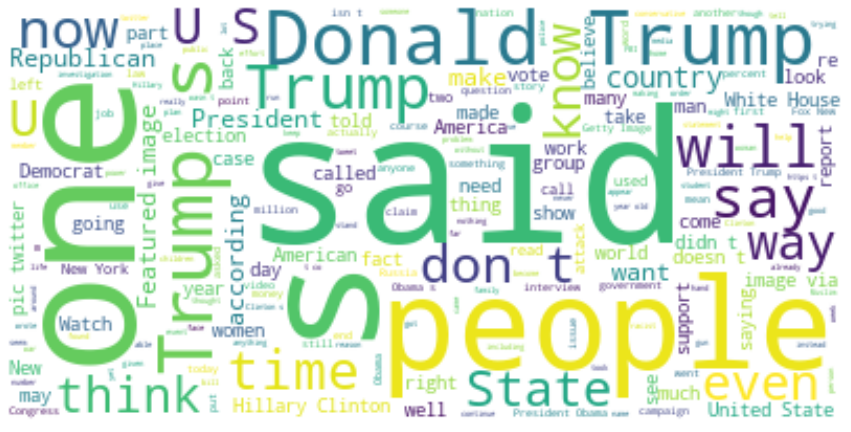

In [5]:
text = " ".join(i for i in false_data['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Labeling 1 for True and 0 for False and merging the datasets

In [3]:
true_data['fake'] = 0
false_data['fake'] = 1
data = pd.concat([true_data, false_data])
data

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


Merge the title into text for ease

In [4]:
data['text'] = data['text'] + ' ' + data['title']
data = data.drop(['title', 'date'], axis=1)
data

,text,subject,fake
0,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0
...,...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,Middle-east,1
23477,21st Century Wire says It s a familiar theme. ...,Middle-east,1
23478,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1
23479,21st Century Wire says Al Jazeera America will...,Middle-east,1


Plotting the frequency of subjects of the news data

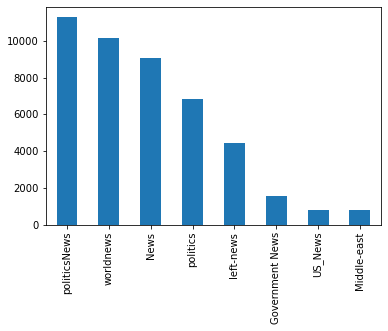

In [5]:
data['subject'].value_counts().plot(kind='bar');

Text(0.5, 1.0, 'Fake news topics')

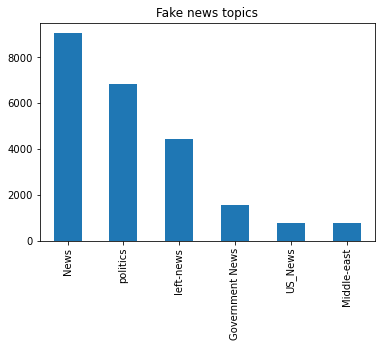

In [6]:
false_data['subject'].value_counts().plot(kind='bar');
plt.title('Fake news topics')

Text(0.5, 1.0, 'True news topics')

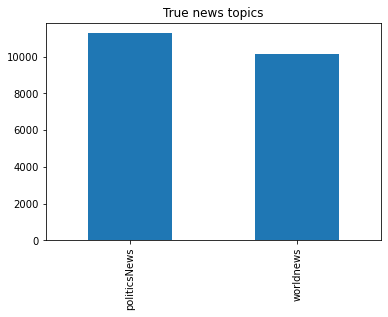

In [7]:
true_data['subject'].value_counts().plot(kind='bar');
plt.title('True news topics')

### Filtering Data

Dopping the subject column to make the data more concise

In [8]:
data = data.drop(['subject'], axis=1)
data

,text,fake
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,1
23477,21st Century Wire says It s a familiar theme. ...,1
23478,Patrick Henningsen 21st Century WireRemember ...,1
23479,21st Century Wire says Al Jazeera America will...,1


Setting the indices for the dataset to clear overlap

In [53]:
indices = np.arange(1, 44899, 1)
data = data.set_index(indices)

### Removing unnecessary words from the text

Making a set of unnecessary words for O(1) lookup and elimination.

In [54]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
unnecessary = punctuation | stop_words

Function that loops through the text and remove the unnecessary words.

In [63]:
def remove_unnecessary(text):
    word_tokens = word_tokenize(text)
    filter_text = []
    for word in word_tokens:
        if word not in unnecessary:
            filter_text.append(word)
    return " ".join(filter_text)

Reference - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/





Applying the function to all the textx in the data

In [71]:
data['text'] = data['text'].apply(remove_unnecessary)

## Splitting into training and testing

In [108]:
x_train,x_test,y_train,y_test = train_test_split(data.text, data.fake, random_state = 5)

In [109]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

Vectorizing the training inputs

In [110]:
Tfidf_vect = TfidfVectorizer(max_features=500)
Tfidf_vect.fit(data['text'])
x_train_tfidf = Tfidf_vect.transform(x_train)
x_test_tfidf = Tfidf_vect.transform(x_test)

# Training and Testing models

## Model: SVM

Training and fitting

In [164]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(x_train_tfidf,y_train)

SVC(gamma='auto', kernel='linear')

Accuracy for training set

In [165]:
svm_train_pred = SVM.predict(x_train_tfidf)

In [166]:
print("Accuracy for Training set:",accuracy_score(svm_train_pred, y_train)*100)
print("\n\nClassification Report:\n")
print(metrics.classification_report(svm_train_pred, y_train))

Accuracy for Training set: 99.37338520476347


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16069
           1       0.99      0.99      0.99     17604

    accuracy                           0.99     33673
   macro avg       0.99      0.99      0.99     33673
weighted avg       0.99      0.99      0.99     33673



Accuracy for the testing set

In [167]:
svm_test_pred = SVM.predict(x_test_tfidf)

In [168]:
print("Accuracy for Training set:",accuracy_score(svm_test_pred, y_test)*100)
print("\n\nClassification Report:\n")
print(metrics.classification_report(svm_test_pred, y_test))

Accuracy for Training set: 99.42093541202672


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5378
           1       0.99      0.99      0.99      5847

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

